### Exploratory Data Analysis

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pylab import rcParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV 
import sklearn.ensemble # part of a sklearn scientific library that holds enseble methods of data analysis such as random forest and gradient boosting


In [2]:
def binary_classification_validation(df, lift=1):
    print(' #### Accuracy: ')
    try:
        print("\nModel Accuracy: %0.2f" % (sklearn.metrics.accuracy_score(df['OBSERVED_TARGET'], df['PREDICTED_TARGET']) *100) + "%")
        print (" \nCohen's Kappa: %0.2f" % (sklearn.metrics.cohen_kappa_score(df['OBSERVED_TARGET'], df['PREDICTED_TARGET']) *100) + "%")
    except:
        print( ' ERROR ')

    print(' #### Classification Report: ')
    try:
        print(sklearn.metrics.classification_report(df['OBSERVED_TARGET'] , df['PREDICTED_TARGET']))
    except:
        print(' ERROR')

    print( ' #### Confusion Matrix ')
    try: 
        x = sklearn.metrics.confusion_matrix(df['OBSERVED_TARGET'], df['PREDICTED_TARGET'], labels = [1,0])
        confusion_matrix = pd.DataFrame(x, columns = ['Pred = 1', 'Pred = 0'], index = ['Obsv = 1', 'Obsv = 0'])
        print(confusion_matrix.to_string())
        #df['PREDICTED_TARGET'].sum()
    except:
        print( 'ERROR')
    print(' # I. Precision Recall curve')
    print(' Calculations')
    try:
        precision, recall, thresholds = sklearn.metrics.precision_recall_curve(df['OBSERVED_TARGET'] , df ['EVENT_PROB'])
    except:
        print(' ERROR ')
    try:
        thresholds = np.append(thresholds, 1)#add 1 since there is n thresholds + 1 points in precision and recall
    #print (len (precision) , len (recall) , len (thresholds) )
    # queue rate is the # of the population that is probable to churn according to the threshold
        queue_rate = []
        for threshold in thresholds:
            queue_rate.append((df['EVENT_PROB'] >= threshold).mean())
        #Get index or 0.5 threshold
        index_p5 = np.where(thresholds>=0.5)[0][0]
         # Compute Area Under the curve (AUC) using the trapezoidal rule
        auc_PR = sklearn.metrics.auc(recall, precision)
    except:
        print('ERROR')
    print(' ### I.a. Precision-Reeall')
    print(' Plot Precision—Recall curve')
    try:
        plt.figure(figsize = [8,8])
        plt.plot(recall, precision, label='Precision-Recall Curve', color = 'r')
        plt.plot(recall[index_p5], precision[index_p5], 'or')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.title('Precision—Recall Curve')
        plt.legend(loc="upper right")
        plt.grid(b=True, which='major', color=[0.9, 0.9, 0.9], linestyle='-')
        plt.show()
    except:
        print('ERROR')
    print('')
    try:
        print("Area Under PR Curve (AP): %0.2f" % auc_PR) #should be same as AP>
    except:
        print ('ERROR')
    print(' ### I.b. Precision Recall and Queue plot')
    try:
        plt.figure(figsize = [8,8])
        plt.plot(thresholds, precision, 'b')
        plt.plot(thresholds, recall, 'r')
        plt.plot(thresholds, queue_rate, 'k')
        plt.plot(thresholds[index_p5], precision[index_p5], 'ob')
        plt.plot(thresholds[index_p5], recall[index_p5], 'or')
        plt.plot(thresholds[index_p5], queue_rate[index_p5] , 'ok')
        #example line
        #plt.plot([0,1], [example_que_ratio, example_que_ratio] , '--' , lw = 2, color=[0.7, 0.7, 0.7])
        #plt.plot(thresholds[index_ex], thresholds[index_ex] , [0,1], '--' , lw = 2, color=[0.7, 0.7, 0.7])
        plt.legend(('Precision' , 'Recall', 'Queue Rate'), frameon=True, loc="upper center")
        plt.xlabel('Probability Threshold')
        plt.ylabel('Ratio')
        plt.title('Precision-Recall—Queue Rate curve')
        plt.grid(b=True, which='major', color=[0.9, 0.9, 0.9], linestyle='-')
        plt.show()
    except:
        print('ERROR')

    print(' # II. ROC')
    # ROC Calculations
    try:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(df['OBSERVED_TARGET'] , df['EVENT_PROB'], drop_intermediate=False)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        print(' ROC Plot')
        plt.figure(figsize = [8,8])
        lw = 2
        plt.plot(fpr, tpr, color='r', lw=lw, label='ROC curve (Area = %0.2f) ' % roc_auc)
        plt.plot([0,1], [0,1], color='k', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel ("False Positive Rate (1—Specificity)")
        plt.ylabel('True Positive Rate (Sensitivity or recall)') 
        plt.title('Receiver Operating Characteristic Churn Predictions')
        plt.legend(loc="lower right")
        plt.show()
    except:
        print('ERROR')
    
    if lift == 0:
        return 
    
    print(' # III. Lift Chart')
    try: 
        df['PRED_DECILE'], deciles = pd.qcut(-df['EVENT_PROB'], 10, labels=False, retbins=True)
    except:
        try:
            df['PRED_DECILE'], deciles = pd.qcut(-df['EVENT_PROB'], 5, labels=False, retbins=True)
        except:
            df['PRED_DECILE'], deciles = pd.qcut(-df['EVENT_PROB'], 4, labels=False, retbins=True)
    try:
        decile_limits = list(zip(-deciles[0:1], -deciles[1:]))
    except:
        print('ERROR')

    #stats on whole dataset
    try:
        positive_obs = df['OBSERVED_TARGET'].sum()
        total_obs = df['OBSERVED_TARGET'].count()
        positive_obs_ratio = positive_obs/float(total_obs)
    except:
        print('ERROR')
    
    print(' #### Group by predicted probability deciles')
          
    # new df Grouped By PREDICTED probability deciles
    try:
        df_decile_grp = df.groupby('PRED_DECILE')
        #Consolidate Results into Output Dataframe
        lift_df = pd.DataFrame({'NUMBER_OF_OBSERVATIONS': df_decile_grp['OBSERVED_TARGET'].count(), 'NUMBER_OF_RESPONCES': df_decile_grp['OBSERVED_TARGET'].sum()})
        lift_df['CUMULATIVE_RESPONSE'] = lift_df['NUMBER_OF_RESPONCES'].cumsum()
        lift_df['RESPONCE_RATE'] = round(lift_df['NUMBER_OF_RESPONCES']/lift_df['NUMBER_OF_OBSERVATIONS']*100, 2)
        lift_df['%_RIGHT'] = round(lift_df['NUMBER_OF_RESPONCES']/positive_obs*100, 2)
        lift_df['GAIN'] = round(lift_df['CUMULATIVE_RESPONSE']/positive_obs*100, 2)
        lift_df['%_POPULATION'] = round(lift_df['NUMBER_OF_RESPONCES']/total_obs*100, 2)
        lift_df['LIFT@DECILE'] = lift_df['%_RIGHT']/lift_df['%_POPULATION']
        
        lift_df['CUM%_POPULATION'] = round(lift_df['NUMBER_OF_OBSERVATIONS']/total_obs*100, 2).cumsum()
        lift_df['CUMULATIVE_LIFT'] = round(lift_df['GAIN']/lift_df['CUM%_POPULATION'],2)
    except:
        print('ERROR')
        
    try:
        print("Total positive observation: " + str(positive_obs))
        print("Total observations: " + str(total_obs))
        print("Observed Positive Class Rate: %0.2f" % (positive_obs_ratio*100)+" %")
        print("\nDecile Limits:")
        print(decile_limits)
    except:
        print('ERROR')
        
    print(' ### III.a. Observed Responce Rate')
    try:
        ##higher_bin = (np.where(lift_df['RESPONCE_RATE'] >= (positive_obs_ratio*100))[0][-1])+1
        plt.figure(figsize = [8,8])
        ax = lift_df['RESPONCE_RATE'].plot(kind='bar', title = "Observed Responce rate (Churn Rate) by Prediction Probability Deciles", figsize = [8,8], legend = True, fontsize=12, color = [0.7,0.7,0.7])
        plt.plot([list(lift_df.index)[0], list(lift_df.index)[-1]], [(positive_obs_ratio*100),(positive_obs_ratio*100)], 'r')
        ax.set_xticklabels(list(lift_df.index+1))
        ax.set_xlabel('Prediction Deciles [Desc]')
        ax.set_ylabel('Responce Rate')
        ax.set_ylim([0,100])
        ax.legend(('Overall Responce Rate', 'Responce Rate per Decile'));
        plt.show()
    except:
        print('ERROR')
    
    print(' ### III.b. Lift Chart')
    print('')
    try:
        plt.figure(figsize=[8,8])
        plt.plot(list(lift_df.index+1), lift_df['CUMULATIVE_LIFT'], color='r')
        plt.plot([1,len(list(lift_df.index+1))], [1,1], color='k', linestyle='--')
        plt.xlabel('Prediction Deciles [Desc]')
        plt.ylabel('Lift')
        plt.title("Lift Chart")
        plt.legend(('Model','Random'), frameon=True, loc='upper right')
        plt.grid(b=True, which='major', color=[0.9,0.9,0.9], linestyle='-')
        plt.ylim([0,2.25])
        plt.show()
    except:
        print('ERROR')
    
    try:
        fraction_of_positives, mean_predictived_value = calibration_curve(df['OBSERVED_TARGET'], df['EVENT_PROB'], n_bins=len(list(lift_df.index)))
        plt.figure(figsize=[8,8])
        ax1 = plt.subplot2grid((2,1),(0,0),rowspan=2)
        ax1.plot([0,1], [0,1], "k:", label='Perfectly Calibrated')
        ax1.plot(mean_predictived_value, fraction_of_positives, "s-", label = 'Model', color='r')
        ax1.set_xlabel("Mean Predicted Probability")
        ax1.set_ylabel("Fraction of Positives")
        ax1.set_ylim([0,1])
        ax1.legend(loc="upper left")
        ax1.set_title('Calibration Plots (Reliability Curve)')
        plt.tight_layout()
        plt.show()
    except:
        print('ERROR')

In [3]:
def classifier_performance(classifier, y_true, y_pred, y_pred_proba):
    print('Predicted_Classes:', classifier.classes_)
    print('Classification Report:')
    print(sklearn.metrics.classification_report(y_true, y_pred))
    print('Confusion Matrix:')
    print(sklearn.metrics.confusion_matrix(y_true, y_pred))
    try:
        print('Accuracy:', sklearn.metrics.accuracy_score(y_true, y_pred))
    except:
        print('Accuracy: FAILED')
    try:
        print("AUC:", sklearn.metrics.roc_auc_score(y_true, y_pred_proba))
    except:
        print('AUC: FAILED')

In [2]:
df_ml_ = pd.read_csv('E:\\User\\jupyter\\neo_ml.csv',dtype={'read_intime':'int','byself':'int','pages':'int','session_nunique':'int'}, low_memory=False)

**read_intime** - 1 read to time of teacher suggetion  

**group of pread** - grouping by % of finished reading of books

**read_result** - count how many times reading

**pread** - % of finished reading of books

**readl** - read-level

**score_mean** - mean value of time that studend stay on the one page of a book

**session_nunique** - quantity user's sessions

**slang** - language of user

In [63]:
df_ml_[df_ml_.byself==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20972 entries, 19 to 93910
Columns: 195 entries, index to group_pread
dtypes: float64(179), int32(3), int64(1), object(12)
memory usage: 31.1+ MB


### we start to analyze the reading results of the suggested book by teachers

In [3]:
df_sudg = df_ml_[df_ml_.byself==0]

In [221]:
df_sudg.describe()

,session_nunique,score_mean,pages,byself,9lj2wk5qqj6eql6qd,9lj2wk1vgjdhp8syb,9lj2wk5qqj6equnls,9lj2wk5qqj6eql6pu,9lj2wk5qqj6eql6qj,9lj2wk5qqj6equnm9,...,9lj2wk5qqj6eql6q1,9lj2wk1vgjdhp8syd,9lj2wk5qqj6eql6qq,9lj2wk4k6j7tc9rre,cy8x6iiq7jk75qjh4,cy8x6ir8kjguch1gk,9lj2wk5qqj6equnms,read_intime,pread,read_result
count,20972.000000,20972.000000,20972.000000,20972.0,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,...,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,1.616965,13.443589,22.470246,0.0,0.087355,0.020694,0.001001,0.016069,0.031947,0.005102,...,0.131127,0.033187,0.528896,0.006866,0.005960,0.004005,0.016212,0.609765,86.007523,3.407503
std,1.513125,19.685379,15.275613,0.0,0.282361,0.142362,0.031629,0.125744,0.175864,0.071248,...,0.337547,0.179129,0.499176,0.082580,0.076975,0.063162,0.126293,0.487814,29.179575,3.599470
min,1.000000,0.000000,6.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.595976,16.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.970000,1.240000
50%,1.000000,9.193146,18.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,100.000000,2.290000
75%,2.000000,16.274500,26.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,100.000000,4.410000
max,78.000000,817.040750,278.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,61.410000


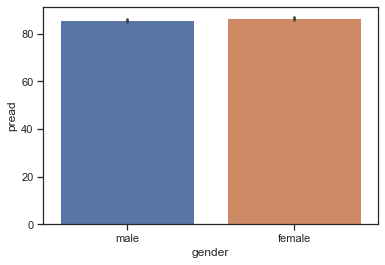

In [66]:
sns.barplot(x='gender',y='pread',data=df_sudg)

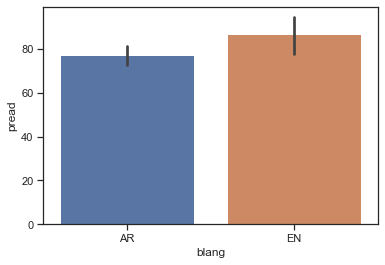

In [6]:
sns.barplot(x='blang',y='pread',data=df_sudg[df_sudg.slang=='EN'])

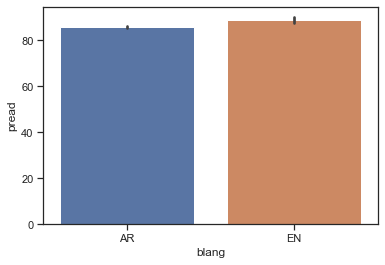

In [5]:
sns.barplot(x='blang',y='pread',data=df_sudg[df_sudg.slang=='AR'])

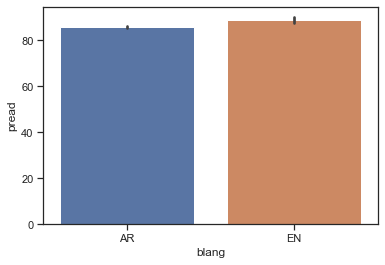

In [4]:
sns.barplot(x='blang',y='pread',data=df_sudg)

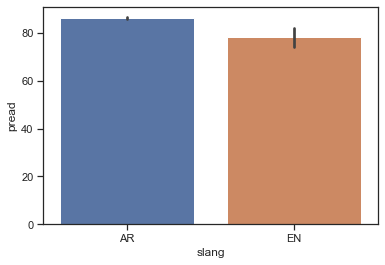

In [67]:
sns.barplot(x='slang',y='pread',data=df_sudg)

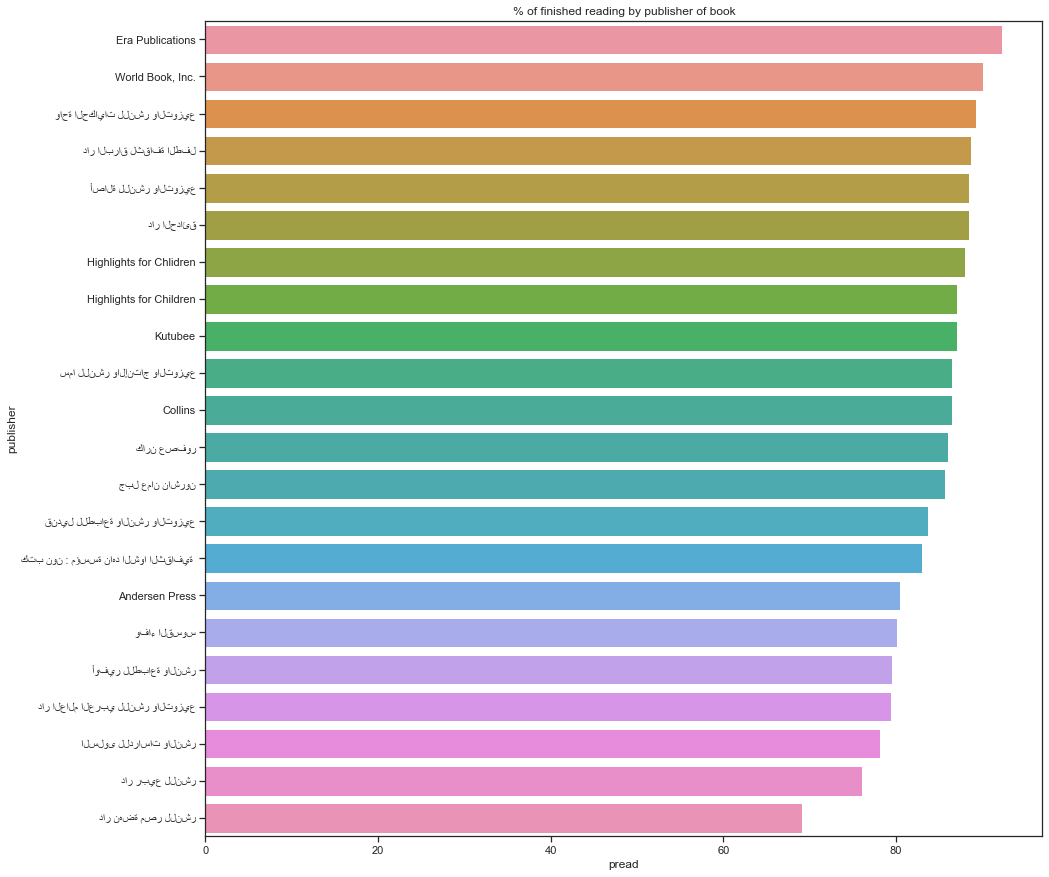

In [68]:
title_ = df_sudg.groupby('publisher')['pread'].mean().reset_index()
title_ = title_.sort_values(['pread','publisher'], ascending=False)
plt.figure(figsize=(15,15))
plt.title('% of finished reading by publisher of book')
sns.barplot(y='publisher',x='pread',data=title_)

 ### A pairs plot allows us to see relationships between "gender" and "% of finished reading of books" variables.
 ### There are the histogram and the scatter plot.

### The histogram on the diagonal allows us to see the distribution the distribution of a single variable "% of finished reading of books" and of categorical variables: gender, language

### The scatter plots on the upper and lower triangles show the relationship (or lack thereof) between three variables whithin these categories: "% of finished reading of books",  "mean value of time that studend stay on the one page of a book", "quantity user's sessions"

### From the histograms, we learn that the population and %read variables divided into two big part: the students who have a hight result and who has a low one

### In the scatter plot we see that %read and score read are weakly correlated showing that the score has not much influence to whish to finish a book, the quantity user's sessions the same

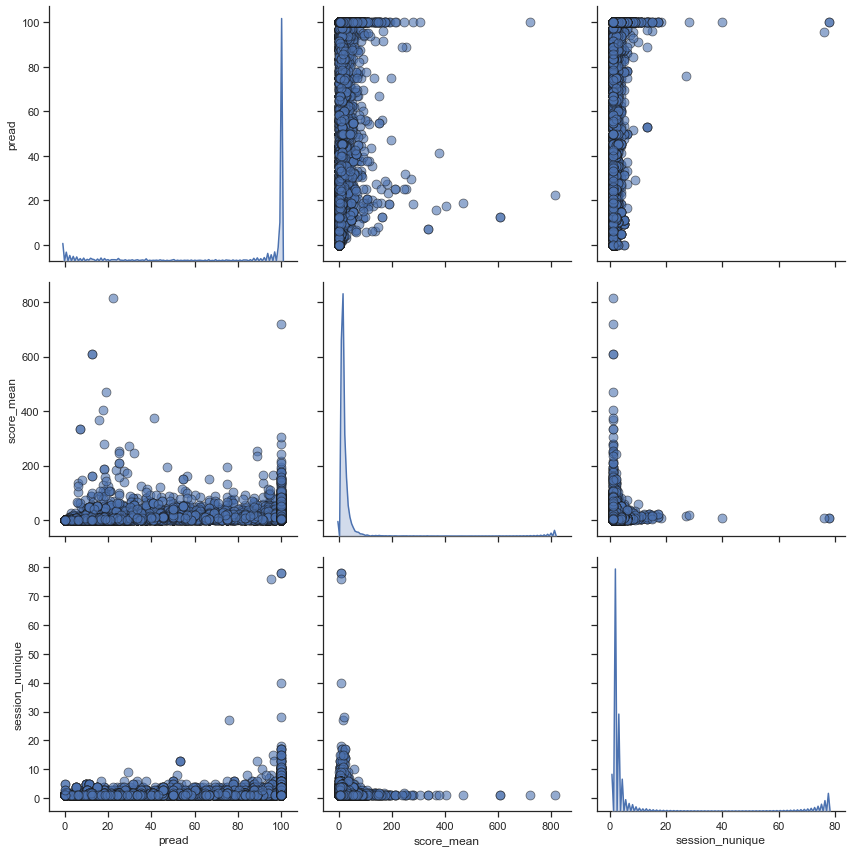

In [69]:
g = sns.pairplot(df_sudg, vars=['pread','score_mean','session_nunique'], palette="husl", diag_kind="kde",  height=4, 
                 plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

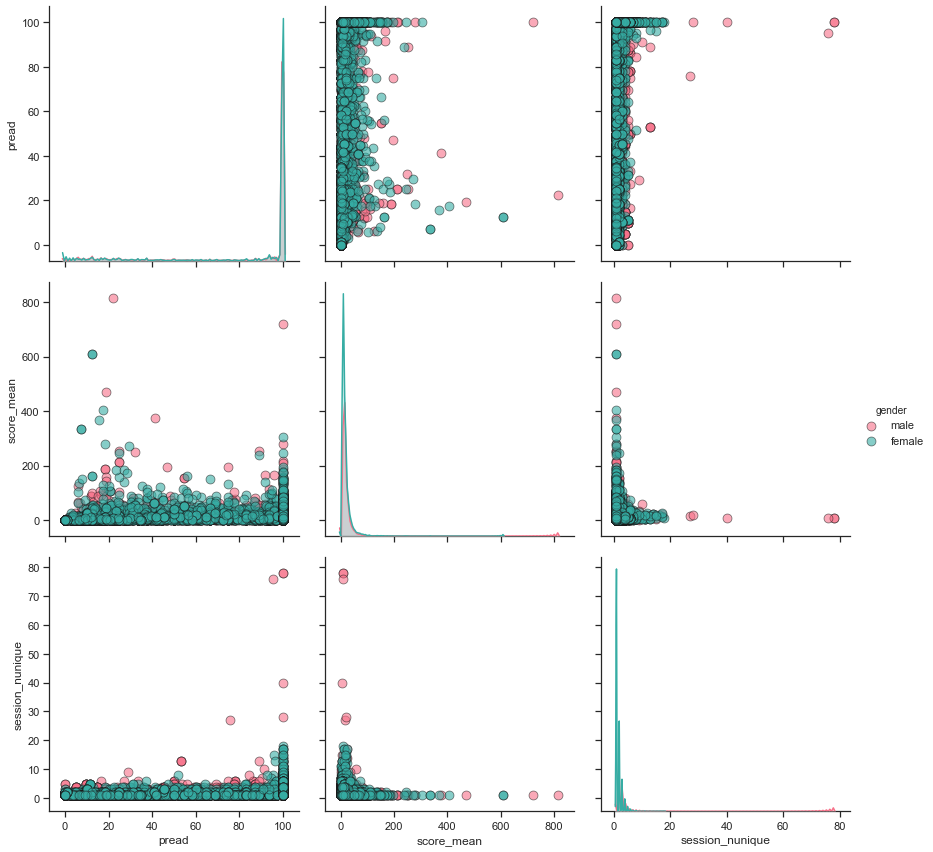

In [70]:
g = sns.pairplot(df_sudg, hue="gender", vars=['pread','score_mean','session_nunique'], palette="husl", diag_kind="kde",  height=4, 
                 plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

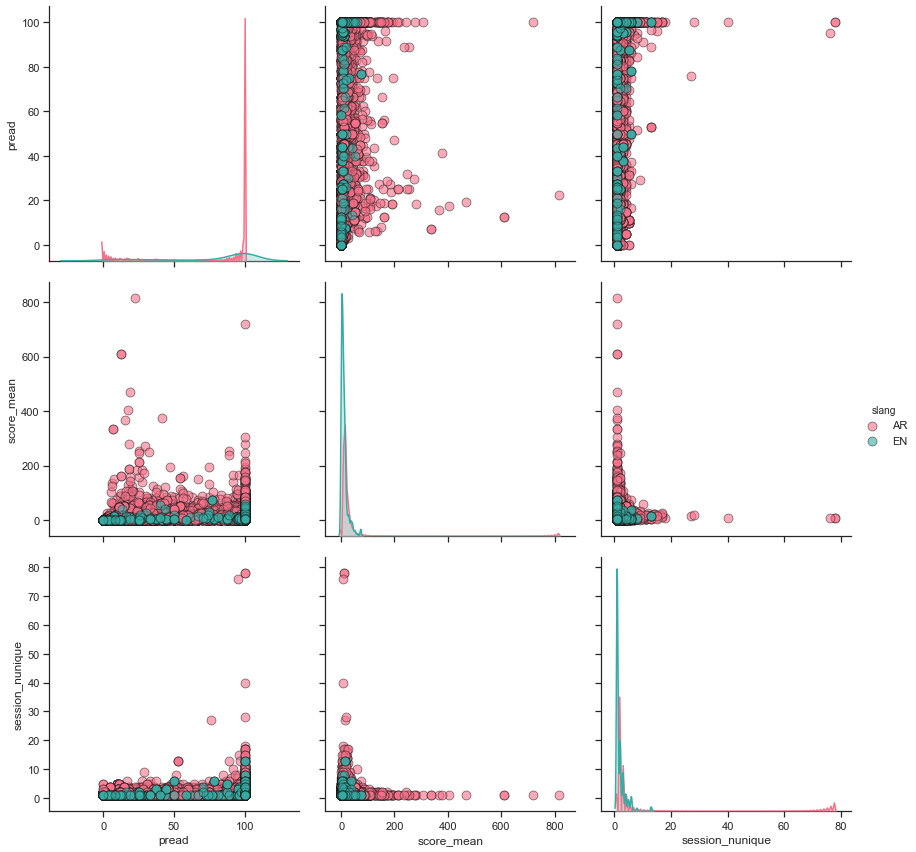

In [71]:
g = sns.pairplot(df_sudg, hue="slang", vars=['pread','score_mean','session_nunique'], palette="husl", diag_kind="kde",  height=4, 
                 plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

In [ ]:
g = sns.pairplot(df_sudg, hue="slang", vars=['pread','score_mean','session_nunique'], palette="husl", diag_kind="kde",  height=4, 
                 plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

read_intime


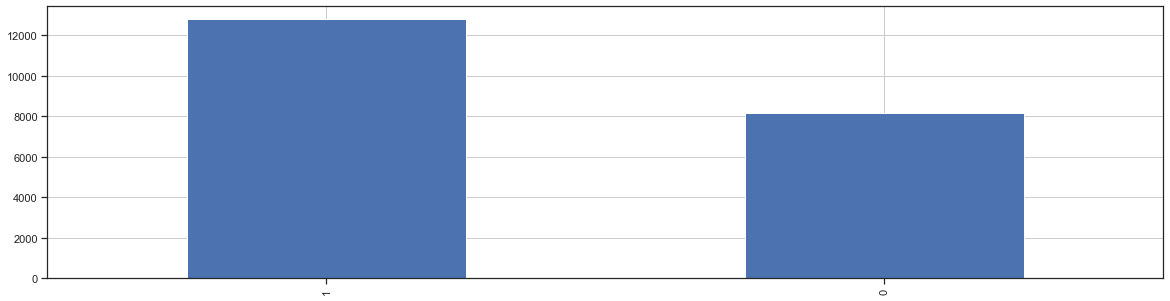

In [72]:
print('read_intime')
df_sudg['read_intime'].value_counts().plot(kind='bar',grid=True, figsize=[20,5])
plt.show()

In [222]:
df_sudg.columns[0:16]

Index(['session_nunique', 'score_mean', 'gender', 'slang', 'pages',
       'publisher', 'author', 'category', 'blang', 'group', 'school',
       'group_id', 'school_id', 'byself', '9lj2wk5qqj6eql6qd',
       '9lj2wk1vgjdhp8syb'],
      dtype='object')

In [224]:
df_sudg.columns[-6:]

Index(['9lj2wk5qqj6equnms', 'read_intime', 'pread', 'read_result',
       'group_pread', 'first_account'],
      dtype='object')

In [6]:
features_to_drop = ['byself','category','group_id', 'school_id']
target_based_features = ['pread','read_result','group_pread']
target = ['read_intime']

### Convert categorical variable into dummy/indicator variable

In [226]:
columns_to_dummies = ['gender', 'slang',
       'publisher', 'author', 'blang','group', 'school']

In [227]:
df_sudg[columns_to_dummies].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20972 entries, 19 to 93910
Data columns (total 7 columns):
gender       20972 non-null object
slang        20972 non-null object
publisher    20972 non-null object
author       20972 non-null object
blang        20972 non-null object
group        20972 non-null object
school       20972 non-null object
dtypes: object(7)
memory usage: 1.3+ MB


In [228]:
df_sudg.groupby('gender').gender.count()

gender
female    10035
male      10937
Name: gender, dtype: int64

In [230]:
df_sudg.groupby('slang').slang.count()

slang
AR    20696
EN      276
Name: slang, dtype: int64

In [231]:
df_sudg.groupby('blang').blang.count()

blang
AR    19333
EN     1639
Name: blang, dtype: int64

In [232]:
df_ml = pd.get_dummies(df_sudg, columns=columns_to_dummies,drop_first=False)
binary_to_drop = ['gender_female', 'slang_EN', 'blang_EN']

In [233]:
df_ml.drop(features_to_drop+target_based_features+binary_to_drop, axis=1, inplace=True)

In [234]:
df_ml.columns

Index(['session_nunique', 'score_mean', 'pages', '9lj2wk5qqj6eql6qd',
       '9lj2wk1vgjdhp8syb', '9lj2wk5qqj6equnls', '9lj2wk5qqj6eql6pu',
       '9lj2wk5qqj6eql6qj', '9lj2wk5qqj6equnm9', '0208ejqj2bgu6',
       ...
       'school_Qurtubah Private Schools', 'school_Rima Naddeh',
       'school_Tajan School', 'school_The Ahliyyah School for Girls (CMS)',
       'school_The Bishop’s School for Boys (BSA)', 'school_The Knowledge Hub',
       'school_The Little Academy', 'school_مدارس الصرح',
       'school_مدرسة راهبات الوردية - الشميساني',
       'school_مدرسة مار يوسف الأهلية'],
      dtype='object', length=713)

In [235]:
df_ml.iloc[:,0:2].describe(include='all')

,session_nunique,score_mean
count,20972.000000,20972.000000
mean,1.616965,13.443589
std,1.513125,19.685379
min,1.000000,0.000000
25%,1.000000,4.595976
50%,1.000000,9.193146
75%,2.000000,16.274500
max,78.000000,817.040750


In [4]:
Study_Train, Study_Test = train_test_split(df_ml,test_size=0.2, random_state=13)
print('Train Shape:', Study_Train.shape)
print('Test Shape:', Study_Test.shape)

Train Shape: (16777, 607)
Test Shape: (4195, 607)


In [7]:
print('train sample size:', Study_Train.shape[0], 'train sample success events:', Study_Train[target].sum())
print('test sample size:', Study_Test.shape[0], 'test sample success events:', Study_Test[target].sum())

train sample size: 16777 train sample success events: read_intime    10260
dtype: int64
test sample size: 4195 test sample success events: read_intime    2528
dtype: int64


In [8]:
x_train = Study_Train.drop(target+['first_account'], axis=1)
y_train = Study_Train[target]

In [239]:
# Build random forest classifier
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500 #Typically Sufficient
                                                 , max_depth=7
                                                 , min_samples_split = 20
                                                 , min_samples_leaf = 10)   

In [240]:
# Import necessary modules
from scipy.stats import randint as sp_randint
from time import time # library for date and time operations

# specify parameters and distributions to sample from
hyperparam_grid = {"max_depth": [5,7,9, None],
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(2, 10), 
              'max_features': ['auto', 'sqrt'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=hyperparam_grid,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

RandomizedSearchCV took 1997.27 seconds for 20 candidates parameter settings.


In [241]:
print(f"\033[1m\033[0mThe best hyperparameters for data:")
for hyperparam in random_search.best_params_.keys():
    print(hyperparam, ": ", random_search.best_params_[hyperparam])
        
print(f"\033[1m\033[94mBest 10-folds CV f1-score: {random_search.best_score_ * 100:.2f}%.")

The best hyperparameters for data:
bootstrap :  False
criterion :  entropy
max_depth :  None
max_features :  sqrt
min_samples_leaf :  4
min_samples_split :  11
Best 10-folds CV f1-score: 72.79%.


**Applying best parameters to our model.**

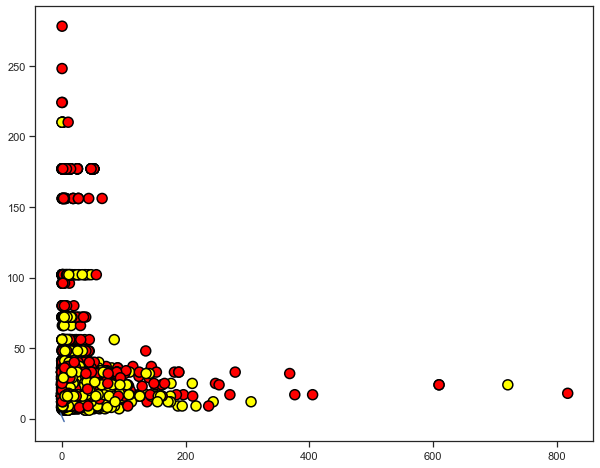

In [29]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(Study_Train.score_mean, Study_Train.pages, c=Study_Train.read_intime, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

In [9]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=500
                                                     , bootstrap= False
                                                     , max_depth= None
                                                     , criterion = 'entropy'
                                                     , max_features = 'sqrt'
                                                     , min_samples_split = 11
                                                     , min_samples_leaf = 4)

classifier = classifier.fit(x_train, y_train)

In [42]:
classifier_feature_importances = pd.DataFrame(columns = ['FEATURE', 'IMPORTANCE'])
classifier_feature_importances['FEATURE'] = x_train.columns
classifier_feature_importances['IMPORTANCE'] = classifier.feature_importances_ 
classifier_feature_importances = classifier_feature_importances.sort_values(by = 'IMPORTANCE', ascending=False)
classifier_feature_importances

,FEATURE,IMPORTANCE
1,score_mean,2.119643e-01
2,pages,6.089873e-02
0,session_nunique,4.040284e-02
582,school_Asamiah International School,1.188178e-02
169,gender_male,1.165316e-02
119,9lj2wk1vgjdhp8sy7,1.086540e-02
180,publisher_السلوى للدراسات والنشر,1.019174e-02
110,9lj2wk5qqj6eql6pi,9.446154e-03
256,author_تغريد عارف النجار,8.683424e-03
593,school_Mayar International Schools,8.364193e-03


In [43]:
feature_importances0 = classifier_feature_importances[classifier_feature_importances.IMPORTANCE == 0]['FEATURE'].to_list()

In [44]:
x_train = Study_Train.drop(target+feature_importances0+['first_account'], axis=1)


In [45]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=500
                                                     , bootstrap= False
                                                     , max_depth= None
                                                     , criterion = 'entropy'
                                                     , max_features = 'sqrt'
                                                     , min_samples_split = 11
                                                     , min_samples_leaf = 4)

classifier = classifier.fit(x_train, y_train)

#### Performance on Train Sample

In [46]:
y_true = y_train

In [47]:
y_pred = classifier.predict(x_train)
y_pred_proba = classifier.predict_proba(x_train)[:,1]


In [252]:
validation_dataframe = pd.DataFrame({'OBSERVED_TARGET':y_true['read_intime'].values})

In [253]:
validation_dataframe['PREDICTED_TARGET'] = y_pred
validation_dataframe['EVENT_PROB'] = y_pred_proba

In [254]:
validation_dataframe.head(10)

,OBSERVED_TARGET,PREDICTED_TARGET,EVENT_PROB
0,1,1,0.832732
1,1,1,0.908827
2,1,1,0.879938
3,1,1,0.554232
4,0,1,0.686250
5,1,1,0.804135
6,0,1,0.666103
7,1,1,0.779395
8,0,0,0.204952
9,1,1,0.897662


In [255]:
classifier_performance(classifier, y_true, y_pred, y_pred_proba)

Predicted_Classes: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.71      6517
           1       0.80      0.88      0.84     10260

    accuracy                           0.80     16777
   macro avg       0.79      0.77      0.78     16777
weighted avg       0.79      0.80      0.79     16777

Confusion Matrix:
[[4276 2241]
 [1181 9079]]
Accuracy: 0.7960302795493831
AUC: 0.8843925438970381


 #### Accuracy: 

Model Accuracy: 79.60%
 
Cohen's Kappa: 55.76%
 #### Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.66      0.71      6517
           1       0.80      0.88      0.84     10260

    accuracy                           0.80     16777
   macro avg       0.79      0.77      0.78     16777
weighted avg       0.79      0.80      0.79     16777

 #### Confusion Matrix 
          Pred = 1  Pred = 0
Obsv = 1      9079      1181
Obsv = 0      2241      4276
 # I. Precision Recall curve
 Calculations
 ### I.a. Precision-Reeall
 Plot Precision—Recall curve


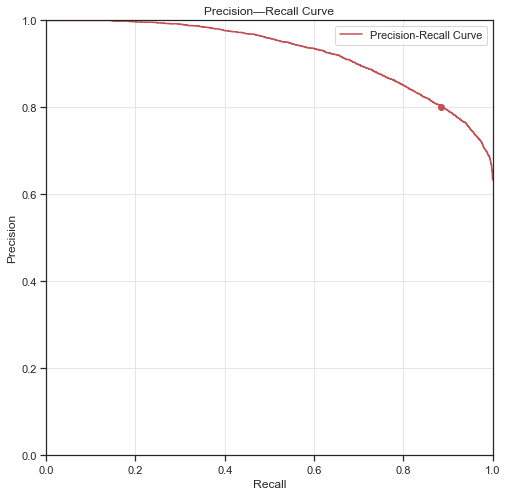


Area Under PR Curve (AP): 0.93
 ### I.b. Precision Recall and Queue plot


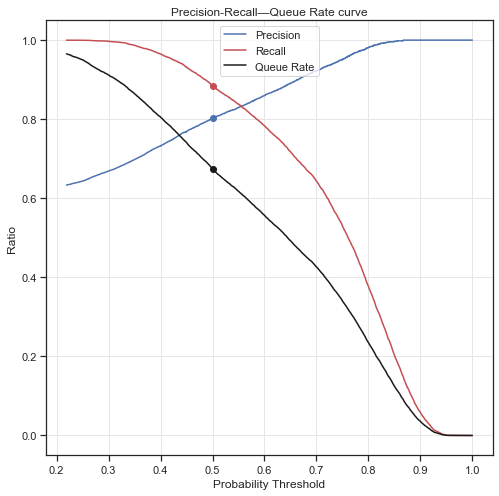

 # II. ROC
 ROC Plot


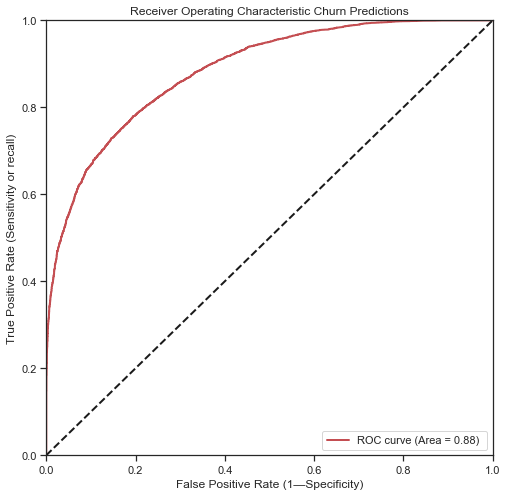

 # III. Lift Chart
 #### Group by predicted probability deciles
Total positive observation: 10260
Total observations: 16777
Observed Positive Class Rate: 61.16 %

Decile Limits:
[(0.9578150564427842, 0.8625469188189839)]
 ### III.a. Observed Responce Rate


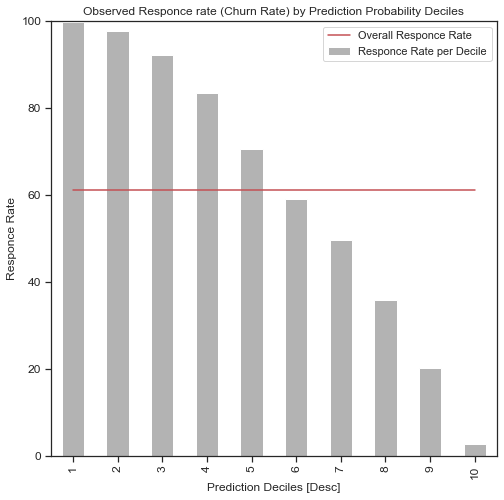

 ### III.b. Lift Chart



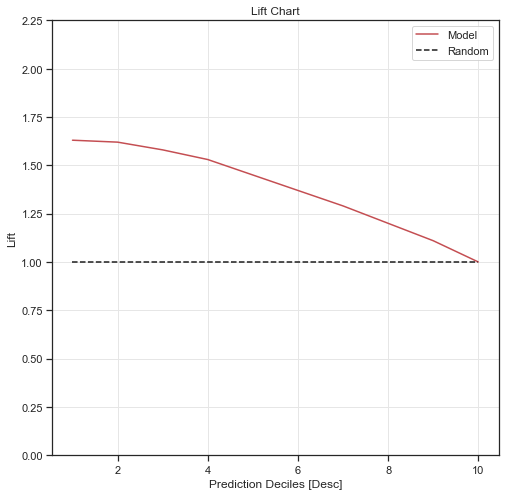

ERROR


In [256]:
binary_classification_validation(df=validation_dataframe)

In [49]:
x = Study_Test.drop(target+feature_importances0+['first_account'], axis=1)
y = Study_Test['read_intime']

y_true = y
y_pred = classifier.predict(x)
y_pred_proba = classifier.predict_proba(x)[:,1]
validation_dataframe = pd.DataFrame()
validation_dataframe['OBSERVED_TARGET'] = y_true
validation_dataframe['PREDICTED_TARGET'] = y_pred
validation_dataframe['EVENT_PROB'] = y_pred_proba

In [51]:
print("Decision tree regressor, MSE = %.2f" % np.sum((y_true - y_pred) ** 2))


Decision tree regressor, MSE = 1097.00


In [259]:
classifier_performance(classifier, y_true, y_pred, y_pred_proba)

Predicted_Classes: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1667
           1       0.76      0.84      0.79      2528

    accuracy                           0.74      4195
   macro avg       0.73      0.71      0.72      4195
weighted avg       0.74      0.74      0.73      4195

Confusion Matrix:
[[ 984  683]
 [ 414 2114]]
Accuracy: 0.7384982121573301
AUC: 0.7996168171429006


#### Performance on Test Sample

 #### Accuracy: 

Model Accuracy: 73.85%
 
Cohen's Kappa: 43.86%
 #### Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1667
           1       0.76      0.84      0.79      2528

    accuracy                           0.74      4195
   macro avg       0.73      0.71      0.72      4195
weighted avg       0.74      0.74      0.73      4195

 #### Confusion Matrix 
          Pred = 1  Pred = 0
Obsv = 1      2114       414
Obsv = 0       683       984
 # I. Precision Recall curve
 Calculations
 ### I.a. Precision-Reeall
 Plot Precision—Recall curve


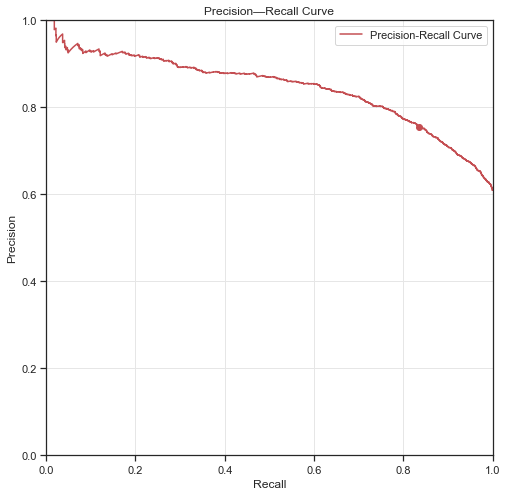


Area Under PR Curve (AP): 0.85
 ### I.b. Precision Recall and Queue plot


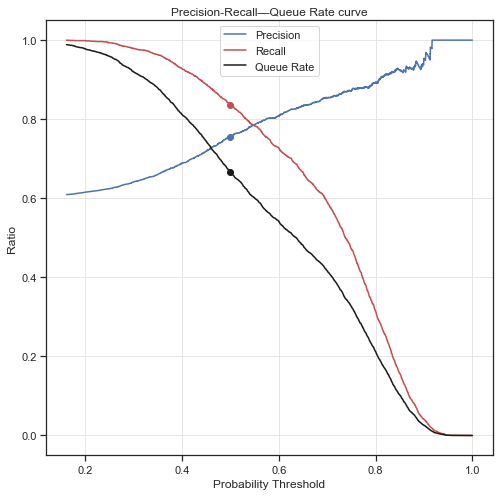

 # II. ROC
 ROC Plot


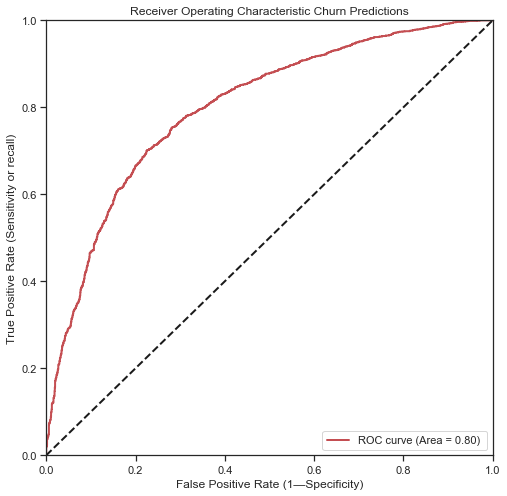

 # III. Lift Chart
 #### Group by predicted probability deciles
Total positive observation: 2528
Total observations: 4195
Observed Positive Class Rate: 60.26 %

Decile Limits:
[(0.9583059071770175, 0.8515904859462142)]
 ### III.a. Observed Responce Rate


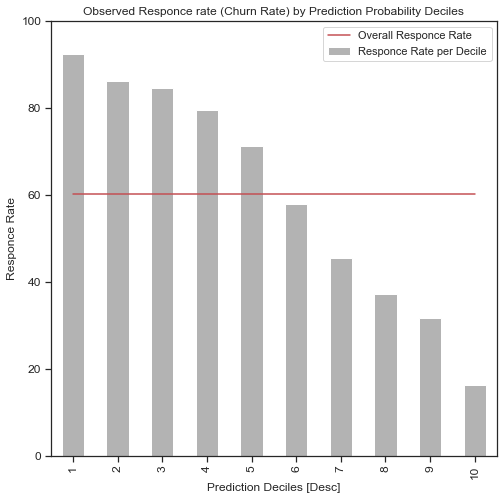

 ### III.b. Lift Chart



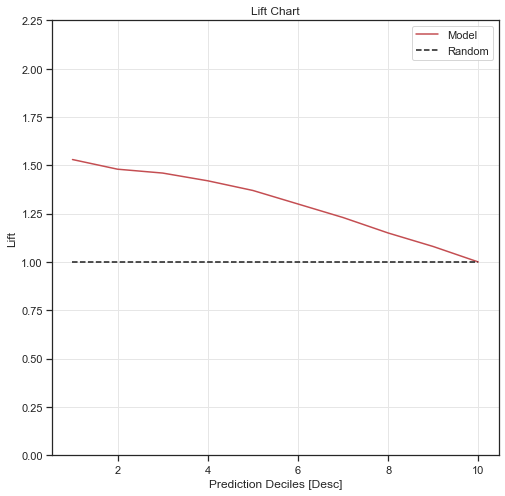

ERROR


In [260]:
binary_classification_validation(df=validation_dataframe)

In [262]:
df_sudg.groupby('school').school.count()

school
ABC School                                        137
Ahliah School - Lebanon                          1000
Al Basma school                                   100
Al Rowad International Schools                     66
Alliance Academy                                   70
Amman Baccalaureate School                       2298
Asamiah International School                     1232
Asriyya School                                   1350
Asriyya School old                                453
BIRIKIM SCHOOLS                                  1056
Baptist School Jordan                               2
Baptist School Lebanon                           1503
Beacon Private School                             157
British School - UAE                              153
Deutsche Internationale Schule Dubai              478
GEMS International School – Al Khail in Dubai    1764
ILC School                                        761
Kindergarten - ASG School                           4
LWIS School Hazmieh  

In [263]:
df_sudg.groupby('group').school.count()

group
1A                   238
1B                   238
1C                   240
1D                   209
2A                   136
                    ... 
فصل 2- هـ             20
فصل 3- هـ              7
فصل 3- و              26
فصل 4- و               3
فصل كتبي في تاجان     50
Name: school, Length: 215, dtype: int64

In [264]:
df_sudg[columns_to_dummies].describe()

,gender,slang,publisher,author,blang,group,school
count,20972,20972,20972,20972,20972,20972,20972
unique,2,2,22,261,2,215,32
top,male,AR,أصالة للنشر والتوزيع,صفاء عزمي,AR,Second Grade B,Mayar International Schools
freq,10937,20696,4077,3770,19333,572,3380


In [272]:
df_ml.columns[3:178] #175 catogeries

Index(['9lj2wk5qqj6eql6qd', '9lj2wk1vgjdhp8syb', '9lj2wk5qqj6equnls',
       '9lj2wk5qqj6eql6pu', '9lj2wk5qqj6eql6qj', '9lj2wk5qqj6equnm9',
       '0208ejqj2bgu6', '9lj2wk5qqj6equnmn', '9lj2wk5qqj6equnlx',
       '9lj2wk5qqj6equnml',
       ...
       'cy8x6ir8kjguch1gr', '9lj2wk5qqj6eql6q8', '9lj2wk5qqj6equnlz',
       '9lj2wk5qqj6eql6q1', '9lj2wk1vgjdhp8syd', '9lj2wk5qqj6eql6qq',
       '9lj2wk4k6j7tc9rre', 'cy8x6iiq7jk75qjh4', 'cy8x6ir8kjguch1gk',
       '9lj2wk5qqj6equnms'],
      dtype='object', length=175)

In [282]:
df_ml.columns[182:204] 

Index(['publisher_Andersen Press', 'publisher_Collins',
       'publisher_Era Publications', 'publisher_Highlights for Children',
       'publisher_Highlights for Chlidren', 'publisher_Kutubee',
       'publisher_World Book, Inc.', 'publisher_أصالة للنشر والتوزيع',
       'publisher_أوفير للطباعة والنشر', 'publisher_السلوى للدراسات والنشر',
       'publisher_جبل عمان ناشرون', 'publisher_دار البراق لثقافة الطفل',
       'publisher_دار الحدائق', 'publisher_دار العالم العربي للنشر والتوزيع',
       'publisher_دار ربيع للنشر', 'publisher_دار نهضة مصر للنشر',
       'publisher_سما للنشر والإنتاج والتوزيع',
       'publisher_قنديل للطباعة والنشر والتوزيع', 'publisher_كارن عصفور',
       'publisher_كتب نون : مؤسسة ناهد الشوا الثقافية ',
       'publisher_واحة الحكايات للنشر والتوزيع', 'publisher_وفاء القسوس'],
      dtype='object')

In [284]:
df_ml.columns[204:465] 

Index(['author_0', 'author_Alison Hawes', 'author_Amanda Graham',
       'author_Andrew Ross', 'author_Andy Belcher', 'author_Angela Scott',
       'author_Anna Claybourne', 'author_Arlene Mark',
       'author_Barbara Bartholomew', 'author_Chris Judge',
       ...
       'author_هشام سليمان', 'author_هشام علوان', 'author_هلا كيلي',
       'author_هند خليفة', 'author_هند عبّاد', 'author_هيلين تشابمان',
       'author_وفاء توفيق القسوس', 'author_يزن مصاروة',
       'author_يعقوب الشاروني', 'author_یزن مصاروة'],
      dtype='object', length=261)

In [286]:
df_ml.columns[465:466] 

Index(['blang_AR'], dtype='object')

In [288]:
df_ml.columns[466:681] 

Index(['group_1A', 'group_1B', 'group_1C', 'group_1D', 'group_2A', 'group_2B',
       'group_2C', 'group_2D', 'group_3A', 'group_3B',
       ...
       'group_صف رابع عرب / عايدة', 'group_صف سابع عرب / محبوبة',
       'group_صف سادس عرب / محبوبة', 'group_صف سادس غير عرب / سها',
       'group_فصل 1- هـ', 'group_فصل 2- هـ', 'group_فصل 3- هـ',
       'group_فصل 3- و', 'group_فصل 4- و', 'group_فصل كتبي في تاجان'],
      dtype='object', length=215)

In [290]:
df_ml.columns[681:] 

Index(['school_ABC School', 'school_Ahliah School - Lebanon',
       'school_Al Basma school', 'school_Al Rowad International Schools',
       'school_Alliance Academy', 'school_Amman Baccalaureate School',
       'school_Asamiah International School', 'school_Asriyya School',
       'school_Asriyya School old', 'school_BIRIKIM SCHOOLS',
       'school_Baptist School Jordan', 'school_Baptist School Lebanon',
       'school_Beacon Private School', 'school_British School - UAE',
       'school_Deutsche Internationale Schule Dubai',
       'school_GEMS International School – Al Khail in Dubai',
       'school_ILC School', 'school_Kindergarten - ASG School',
       'school_LWIS School Hazmieh', 'school_Mayar International Schools',
       'school_NWPS', 'school_National Orthodox School',
       'school_Qurtubah Private Schools', 'school_Rima Naddeh',
       'school_Tajan School', 'school_The Ahliyyah School for Girls (CMS)',
       'school_The Bishop’s School for Boys (BSA)', 'school_The K

In [291]:
Study_Train, Study_Test = train_test_split(df_ml,test_size=0.2, random_state=13)
print('Train Shape:', Study_Train.shape)
print('Test Shape:', Study_Test.shape)

Train Shape: (16777, 713)
Test Shape: (4195, 713)


In [292]:
print('train sample size:', Study_Train.shape[0], 'train sample success events:', Study_Train[target].sum())
print('test sample size:', Study_Test.shape[0], 'test sample success events:', Study_Test[target].sum())

train sample size: 16777 train sample success events: read_intime    10260
dtype: int64
test sample size: 4195 test sample success events: read_intime    2528
dtype: int64


In [376]:
allcount = Study_Train.read_intime.count()

In [324]:
publishers = Study_Train.columns[182:204] 
sum_publishers = Study_Train[publishers].sum(axis=0)
sum_publishers = sum_publishers/allcount
sum_publishers

publisher_Andersen Press                          0.007928
publisher_Collins                                 0.125350
publisher_Era Publications                        0.026584
publisher_Highlights for Children                 0.008881
publisher_Highlights for Chlidren                 0.001311
publisher_Kutubee                                 0.016570
publisher_World Book, Inc.                        0.020921
publisher_أصالة للنشر والتوزيع                    0.196281
publisher_أوفير للطباعة والنشر                    0.020564
publisher_السلوى للدراسات والنشر                  0.076593
publisher_جبل عمان ناشرون                         0.085117
publisher_دار البراق لثقافة الطفل                 0.000656
publisher_دار الحدائق                             0.075282
publisher_دار العالم العربي للنشر والتوزيع        0.020504
publisher_دار ربيع للنشر                          0.026465
publisher_دار نهضة مصر للنشر                      0.010371
publisher_سما للنشر والإنتاج والتوزيع             0.0331

In [429]:
sum_publishers.describe()

count    22.000000
mean      0.045455
std       0.056107
min       0.000656
25%       0.008792
50%       0.020743
75%       0.068248
max       0.196281
dtype: float64

In [422]:
authors = Study_Train.columns[204:465]  
sum_authors = Study_Train[authors].sum(axis=0)
sum_authors = sum_authors/allcount
sum_authors

author_0                    0.069977
author_Alison Hawes         0.003278
author_Amanda Graham        0.000179
author_Andrew Ross          0.003815
author_Andy Belcher         0.001311
                              ...   
author_هيلين تشابمان        0.001013
author_وفاء توفيق القسوس    0.007033
author_يزن مصاروة           0.000596
author_يعقوب الشاروني       0.000536
author_یزن مصاروة           0.000477
Length: 261, dtype: float64

In [428]:
sum_authors.describe()

count    261.000000
mean       0.003831
std        0.013399
min        0.000000
25%        0.000358
50%        0.001013
75%        0.002742
max        0.178459
dtype: float64

In [423]:
groups = Study_Train.columns[466:681] 
sum_groups = Study_Train[groups].sum(axis=0)
sum_groups = sum_groups/allcount
sum_groups

group_1A                   0.012279
group_1B                   0.011742
group_1C                   0.011504
group_1D                   0.009596
group_2A                   0.006676
                             ...   
group_فصل 2- هـ            0.001073
group_فصل 3- هـ            0.000298
group_فصل 3- و             0.001133
group_فصل 4- و             0.000179
group_فصل كتبي في تاجان    0.002503
Length: 215, dtype: float64

In [425]:
sum_groups.describe()

count    215.000000
mean       0.004651
std        0.005834
min        0.000000
25%        0.000358
50%        0.001967
75%        0.007808
max        0.027478
dtype: float64

In [397]:
schools = Study_Train.columns[681:]  
sum_schools = Study_Train[schools].sum(axis=0)
sum_schools = sum_schools/allcount
sum_schools

school_ABC School                                       0.006557
school_Ahliah School - Lebanon                          0.048400
school_Al Basma school                                  0.005066
school_Al Rowad International Schools                   0.003040
school_Alliance Academy                                 0.002980
school_Amman Baccalaureate School                       0.109793
school_Asamiah International School                     0.058890
school_Asriyya School                                   0.063122
school_Asriyya School old                               0.022412
school_BIRIKIM SCHOOLS                                  0.049472
school_Baptist School Jordan                            0.000119
school_Baptist School Lebanon                           0.072838
school_Beacon Private School                            0.007689
school_British School - UAE                             0.006914
school_Deutsche Internationale Schule Dubai             0.023306
school_GEMS International

In [426]:
sum_schools.describe()

count    32.000000
mean      0.031250
std       0.041312
min       0.000119
25%       0.002816
50%       0.007302
75%       0.051827
max       0.159206
dtype: float64

In [395]:
sum_schools.sum()

1.0

In [455]:
categories = Study_Train.columns[3:178]
sum_categories = Study_Train[categories].sum(axis=0)
sum_categories = sum_categories/allcount
sum_categories

9lj2wk5qqj6eql6qd    0.086130
9lj2wk1vgjdhp8syb    0.020504
9lj2wk5qqj6equnls    0.000954
9lj2wk5qqj6eql6pu    0.016988
9lj2wk5qqj6eql6qj    0.032664
                       ...   
9lj2wk5qqj6eql6qq    0.527687
9lj2wk4k6j7tc9rre    0.006735
cy8x6iiq7jk75qjh4    0.006259
cy8x6ir8kjguch1gk    0.004172
9lj2wk5qqj6equnms    0.015974
Length: 175, dtype: float64

In [457]:
sum_categories.describe()

count    175.000000
mean       0.033741
std        0.063213
min        0.000000
25%        0.003994
50%        0.010193
75%        0.039489
max        0.527687
dtype: float64

In [396]:
Study_Train.groupby('read_intime').read_intime.count()

read_intime
0     6517
1    10260
Name: read_intime, dtype: int64

In [392]:
from collections import Counter
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

class_weights = get_class_weights(Study_Train.read_intime.values)

In [393]:
class_weights

{1: 1.0, 0: 1.57}

In [431]:
def get_p(row, list_, group_):
    for i in list_:
        if getattr(row, i) == 1:
            p = group_[i]
            break
    return p

In [458]:
data_sample_weight1 = Study_Train.apply(get_p, axis=1, list_=schools, group_=sum_schools)
data_sample_weight2 = Study_Train.apply(get_p, axis=1, list_=authors, group_=sum_authors)
data_sample_weight3 = Study_Train.apply(get_p, axis=1, list_=publishers, group_=sum_publishers)
data_sample_weight4 = Study_Train.apply(get_p, axis=1, list_=categories, group_=sum_categories)

In [459]:
data_sample_weight = data_sample_weight1*data_sample_weight3*data_sample_weight3**data_sample_weight4

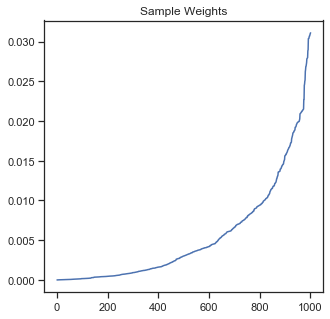

In [460]:
plt.figure(figsize = [5,5])
plt.title('Sample Weights')
plt.plot(np.sort(data_sample_weight.unique()))
plt.show()

In [461]:
x_train = Study_Train.drop(target+['first_account'], axis=1)
y_train = Study_Train[target]

In [462]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=500
                                                     , bootstrap= False
                                                     , max_depth= None
                                                     , criterion = 'entropy'
                                                     , max_features = 'sqrt'
                                                     , min_samples_split = 11
                                                     , min_samples_leaf = 4)

classifier = classifier.fit(x_train, y_train, sample_weight = data_sample_weight)

In [481]:
classifier_feature_importances = pd.DataFrame(columns = ['FEATURE', 'IMPORTANCE'])
classifier_feature_importances['FEATURE'] = x_train.columns
classifier_feature_importances['IMPORTANCE'] = classifier.feature_importances_ 
classifier_feature_importances = classifier_feature_importances.sort_values(by = 'IMPORTANCE', ascending=False)
classifier_feature_importances

,FEATURE,IMPORTANCE
1,score_mean,0.210836
2,pages,0.057730
0,session_nunique,0.043581
698,school_Mayar International Schools,0.016660
178,gender_male,0.012208
685,school_Asamiah International School,0.011303
202,author_0,0.010521
389,author_كارولين حمادة,0.009349
158,9lj2wk5qqj6eqk249,0.009138
124,cy8x6iiq7jk75qjhs,0.009096


In [482]:
feature_importances0 = classifier_feature_importances[classifier_feature_importances.IMPORTANCE == 0]['FEATURE'].to_list()

In [484]:
x_train = Study_Train.drop(target+['first_account']+feature_importances0, axis=1)
y_train = Study_Train[target]

In [485]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=500
                                                     , bootstrap= False
                                                     , max_depth= None
                                                     , criterion = 'entropy'
                                                     , max_features = 'sqrt'
                                                     , min_samples_split = 11
                                                     , min_samples_leaf = 4)

classifier = classifier.fit(x_train, y_train, sample_weight = data_sample_weight)

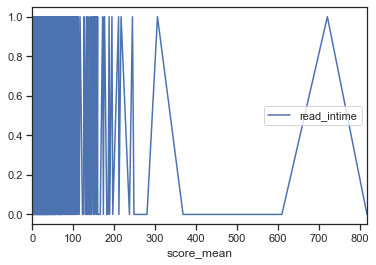

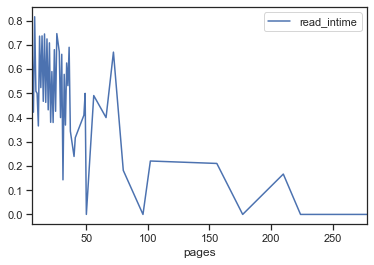

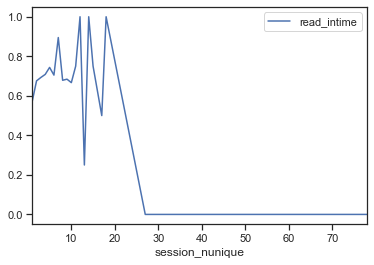

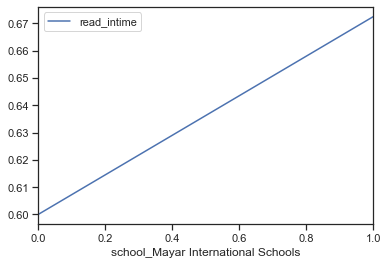

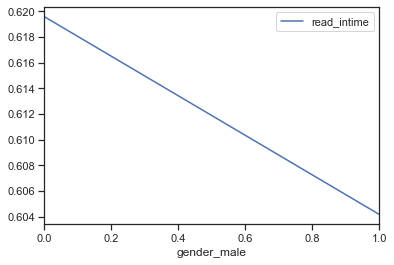

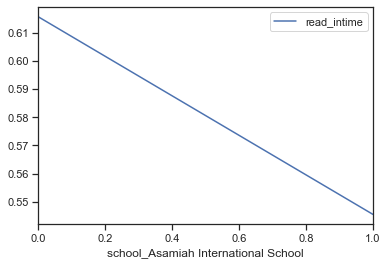

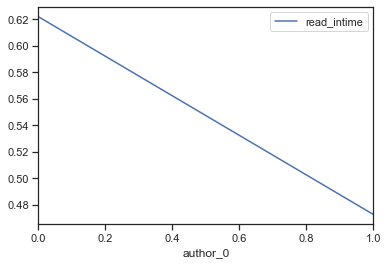

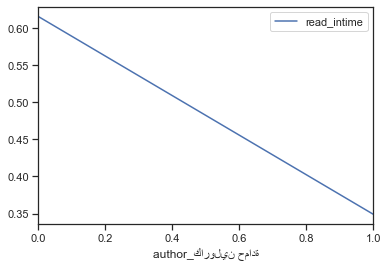

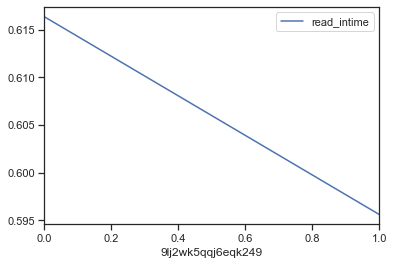

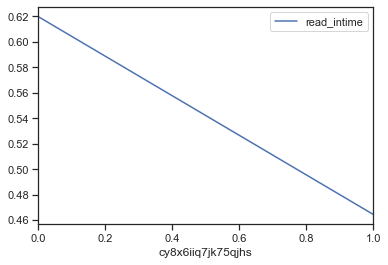

In [486]:
features = classifier_feature_importances[:10]
for f in features['FEATURE'][:10].values:
    Study_Train[[f, 'read_intime']].groupby(f).mean().plot()

In [487]:
y_true = y_train
y_pred = classifier.predict(x_train)
y_pred_proba = classifier.predict_proba(x_train)[:,1]
validation_dataframe = pd.DataFrame()
validation_dataframe = pd.DataFrame({'OBSERVED_TARGET':y_true['read_intime'].values})
#validation_dataframe['OBSERVED_TARGET'] = y_true
validation_dataframe['PREDICTED_TARGET'] = y_pred
validation_dataframe['EVENT_PROB'] = y_pred_proba

In [488]:
classifier_performance(classifier, y_true, y_pred, y_pred_proba)

Predicted_Classes: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71      6517
           1       0.80      0.89      0.84     10260

    accuracy                           0.79     16777
   macro avg       0.79      0.77      0.77     16777
weighted avg       0.79      0.79      0.79     16777

Confusion Matrix:
[[4196 2321]
 [1147 9113]]
Accuracy: 0.7932884305894975
AUC: 0.878181602412763


 #### Accuracy: 

Model Accuracy: 79.33%
 
Cohen's Kappa: 55.01%
 #### Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.64      0.71      6517
           1       0.80      0.89      0.84     10260

    accuracy                           0.79     16777
   macro avg       0.79      0.77      0.77     16777
weighted avg       0.79      0.79      0.79     16777

 #### Confusion Matrix 
          Pred = 1  Pred = 0
Obsv = 1      9113      1147
Obsv = 0      2321      4196
 # I. Precision Recall curve
 Calculations
 ### I.a. Precision-Reeall
 Plot Precision—Recall curve


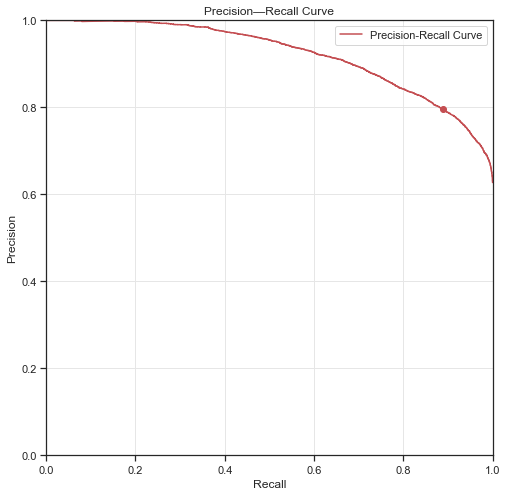


Area Under PR Curve (AP): 0.92
 ### I.b. Precision Recall and Queue plot


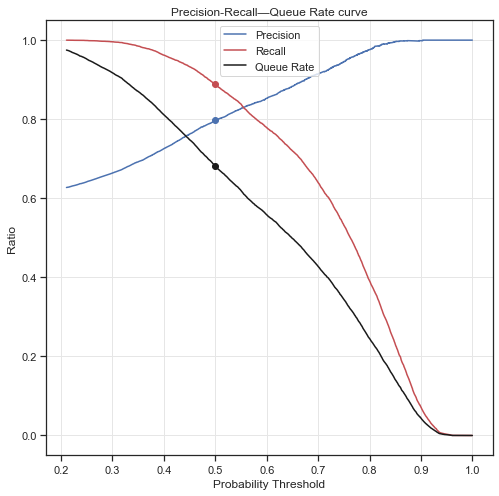

 # II. ROC
 ROC Plot


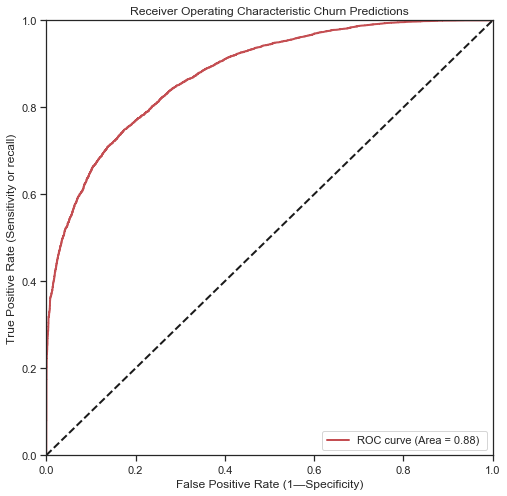

 # III. Lift Chart
 #### Group by predicted probability deciles
Total positive observation: 10260
Total observations: 16777
Observed Positive Class Rate: 61.16 %

Decile Limits:
[(0.9609548311291367, 0.8704094659921446)]
 ### III.a. Observed Responce Rate


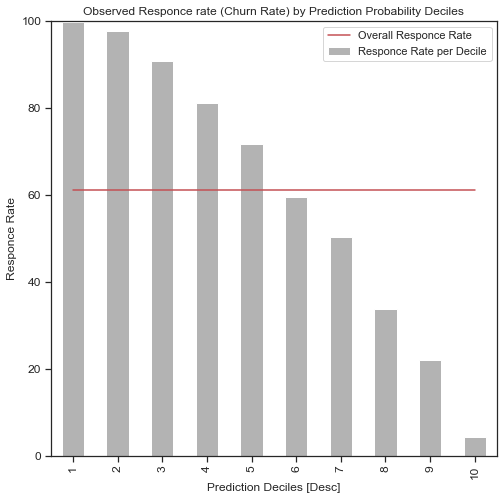

 ### III.b. Lift Chart



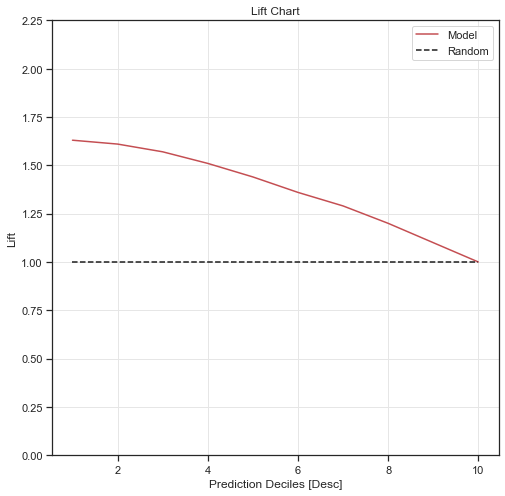

ERROR


In [489]:
binary_classification_validation(validation_dataframe)

In [490]:
x = Study_Test.drop(target+['first_account']+feature_importances0, axis=1)
y = Study_Test[target]

y_true = y
y_pred = classifier.predict(x)
y_pred_proba = classifier.predict_proba(x)[:,1]
validation_dataframe = pd.DataFrame()
validation_dataframe = pd.DataFrame({'OBSERVED_TARGET':y_true['read_intime'].values})
validation_dataframe['PREDICTED_TARGET'] = y_pred
validation_dataframe['EVENT_PROB'] = y_pred_proba

In [491]:
classifier_performance(classifier, y_true, y_pred, y_pred_proba)

Predicted_Classes: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1667
           1       0.75      0.84      0.79      2528

    accuracy                           0.73      4195
   macro avg       0.72      0.70      0.71      4195
weighted avg       0.73      0.73      0.73      4195

Confusion Matrix:
[[ 951  716]
 [ 408 2120]]
Accuracy: 0.732061978545888
AUC: 0.7917482563613859


 #### Accuracy: 

Model Accuracy: 73.21%
 
Cohen's Kappa: 42.24%
 #### Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1667
           1       0.75      0.84      0.79      2528

    accuracy                           0.73      4195
   macro avg       0.72      0.70      0.71      4195
weighted avg       0.73      0.73      0.73      4195

 #### Confusion Matrix 
          Pred = 1  Pred = 0
Obsv = 1      2120       408
Obsv = 0       716       951
 # I. Precision Recall curve
 Calculations
 ### I.a. Precision-Reeall
 Plot Precision—Recall curve


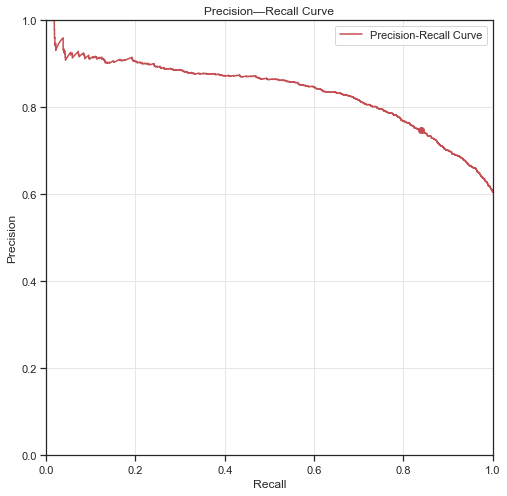


Area Under PR Curve (AP): 0.84
 ### I.b. Precision Recall and Queue plot


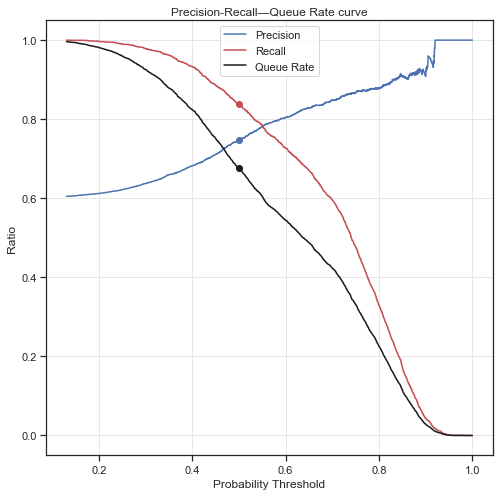

 # II. ROC
 ROC Plot


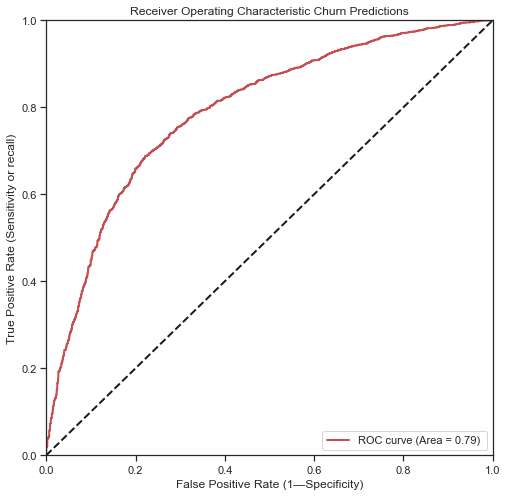

 # III. Lift Chart
 #### Group by predicted probability deciles
Total positive observation: 2528
Total observations: 4195
Observed Positive Class Rate: 60.26 %

Decile Limits:
[(0.9565543766399577, 0.8568854192587105)]
 ### III.a. Observed Responce Rate


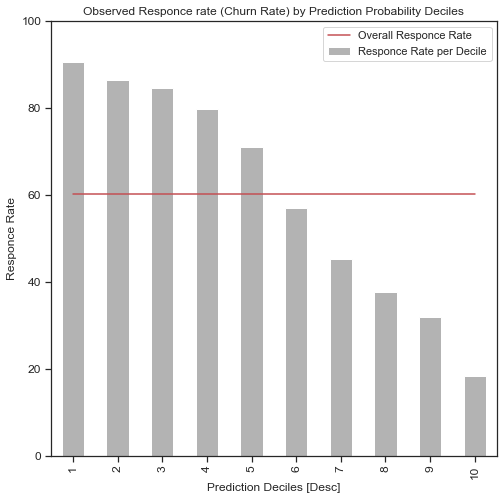

 ### III.b. Lift Chart



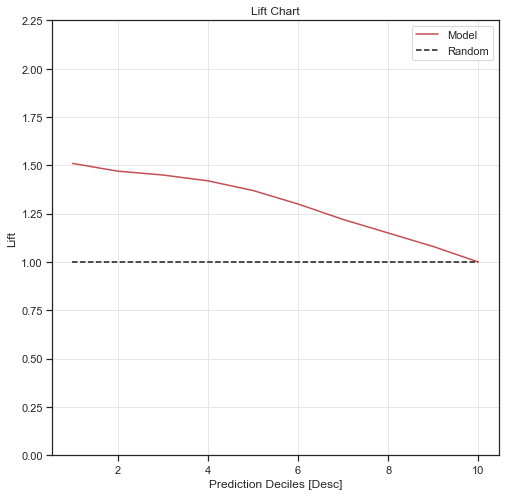

ERROR


In [492]:
binary_classification_validation(validation_dataframe)

In [495]:
x_train = Study_Train.drop(target+['first_account']+feature_importances0, axis=1)
y_train = Study_Train[target]

In [496]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=500
                                                     , bootstrap= False
                                                     , max_depth= None
                                                     , criterion = 'entropy'
                                                     , max_features = 'sqrt'
                                                     , min_samples_split = 11
                                                     , min_samples_leaf = 4
                                                     , class_weight=class_weights)

classifier = classifier.fit(x_train, y_train, sample_weight = data_sample_weight)

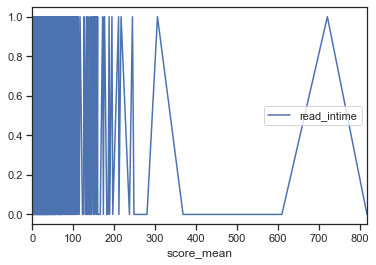

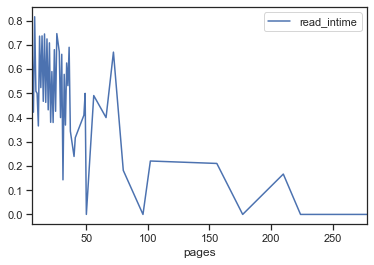

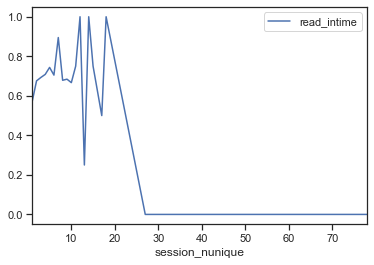

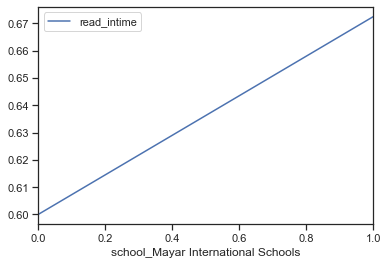

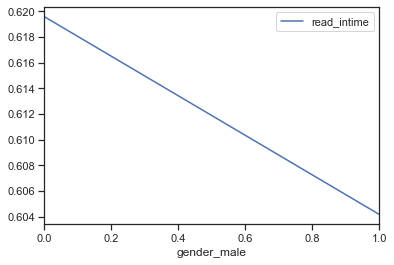

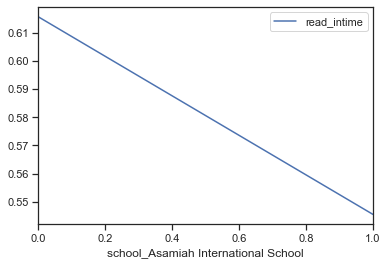

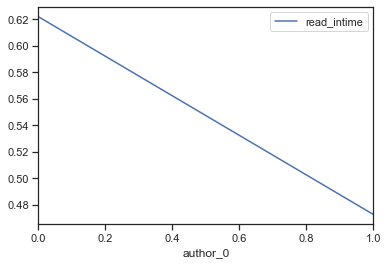

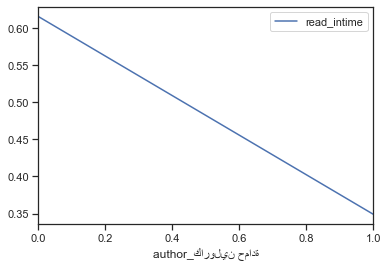

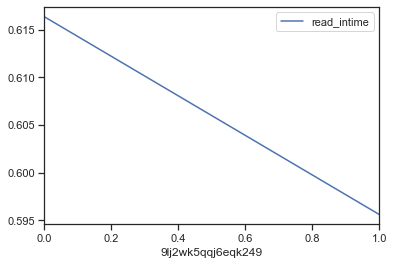

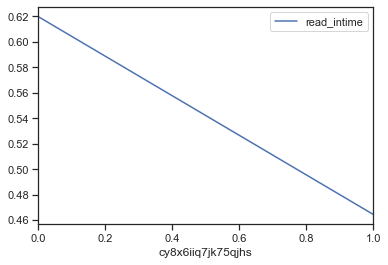

In [497]:
features = classifier_feature_importances[:10]
for f in features['FEATURE'][:10].values:
    Study_Train[[f, 'read_intime']].groupby(f).mean().plot()

In [498]:
y_true = y_train
y_pred = classifier.predict(x_train)
y_pred_proba = classifier.predict_proba(x_train)[:,1]
validation_dataframe = pd.DataFrame()
validation_dataframe = pd.DataFrame({'OBSERVED_TARGET':y_true['read_intime'].values})
#validation_dataframe['OBSERVED_TARGET'] = y_true
validation_dataframe['PREDICTED_TARGET'] = y_pred
validation_dataframe['EVENT_PROB'] = y_pred_proba

In [499]:
classifier_performance(classifier, y_true, y_pred, y_pred_proba)

Predicted_Classes: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      6517
           1       0.85      0.79      0.82     10260

    accuracy                           0.78     16777
   macro avg       0.77      0.78      0.78     16777
weighted avg       0.79      0.78      0.79     16777

Confusion Matrix:
[[5098 1419]
 [2204 8056]]
Accuracy: 0.7840495917029267
AUC: 0.8772524236357693


 #### Accuracy: 

Model Accuracy: 78.40%
 
Cohen's Kappa: 55.52%
 #### Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      6517
           1       0.85      0.79      0.82     10260

    accuracy                           0.78     16777
   macro avg       0.77      0.78      0.78     16777
weighted avg       0.79      0.78      0.79     16777

 #### Confusion Matrix 
          Pred = 1  Pred = 0
Obsv = 1      8056      2204
Obsv = 0      1419      5098
 # I. Precision Recall curve
 Calculations
 ### I.a. Precision-Reeall
 Plot Precision—Recall curve


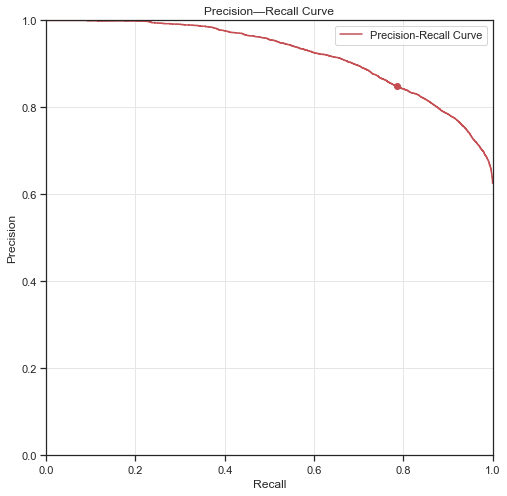


Area Under PR Curve (AP): 0.92
 ### I.b. Precision Recall and Queue plot


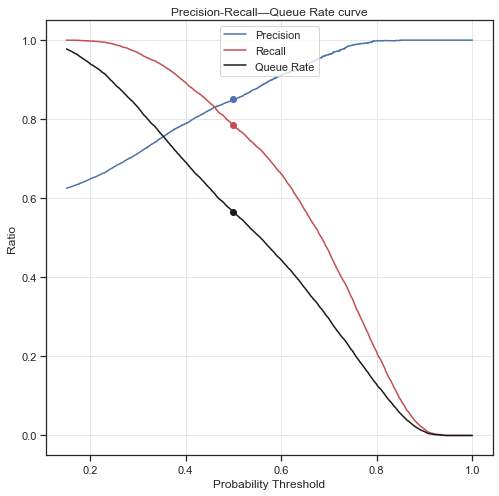

 # II. ROC
 ROC Plot


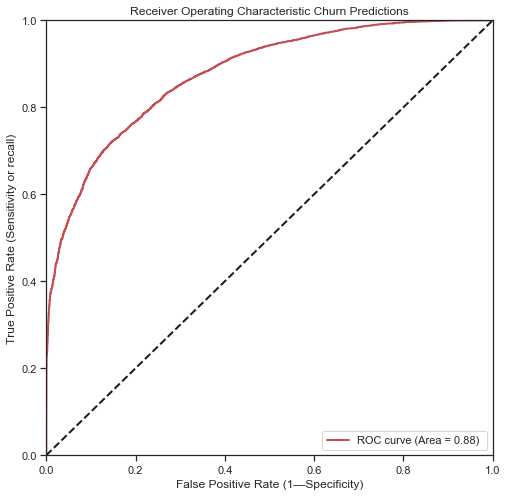

 # III. Lift Chart
 #### Group by predicted probability deciles
Total positive observation: 10260
Total observations: 16777
Observed Positive Class Rate: 61.16 %

Decile Limits:
[(0.9463530547432354, 0.8187556840738927)]
 ### III.a. Observed Responce Rate


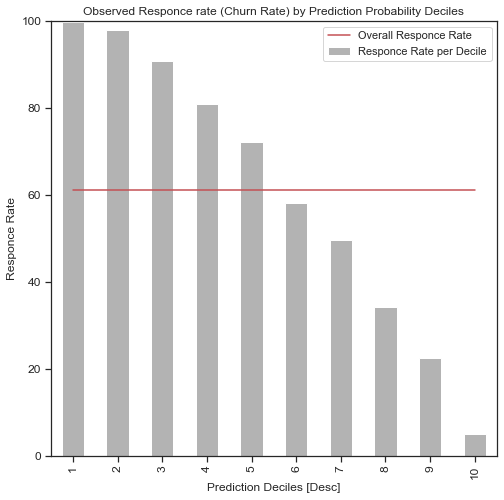

 ### III.b. Lift Chart



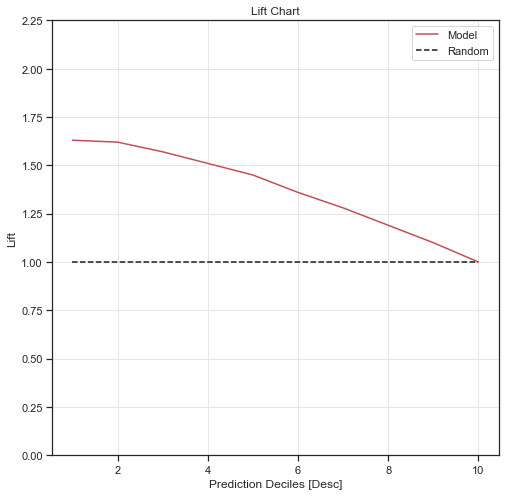

ERROR


In [500]:
binary_classification_validation(validation_dataframe)

In [102]:
x = Study_Test.drop(target+['first_account']+feature_importances0, axis=1)
y = Study_Test[target]


In [501]:

y_true = y
y_pred = classifier.predict(x)
y_pred_proba = classifier.predict_proba(x)[:,1]
validation_dataframe = pd.DataFrame()
validation_dataframe = pd.DataFrame({'OBSERVED_TARGET':y_true['read_intime'].values})
validation_dataframe['PREDICTED_TARGET'] = y_pred
validation_dataframe['EVENT_PROB'] = y_pred_proba

In [502]:
classifier_performance(classifier, y_true, y_pred, y_pred_proba)

Predicted_Classes: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1667
           1       0.80      0.74      0.77      2528

    accuracy                           0.73      4195
   macro avg       0.72      0.73      0.72      4195
weighted avg       0.74      0.73      0.73      4195

Confusion Matrix:
[[1203  464]
 [ 667 1861]]
Accuracy: 0.7303933253873659
AUC: 0.7901433162734541


 #### Accuracy: 

Model Accuracy: 73.04%
 
Cohen's Kappa: 44.85%
 #### Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1667
           1       0.80      0.74      0.77      2528

    accuracy                           0.73      4195
   macro avg       0.72      0.73      0.72      4195
weighted avg       0.74      0.73      0.73      4195

 #### Confusion Matrix 
          Pred = 1  Pred = 0
Obsv = 1      1861       667
Obsv = 0       464      1203
 # I. Precision Recall curve
 Calculations
 ### I.a. Precision-Reeall
 Plot Precision—Recall curve


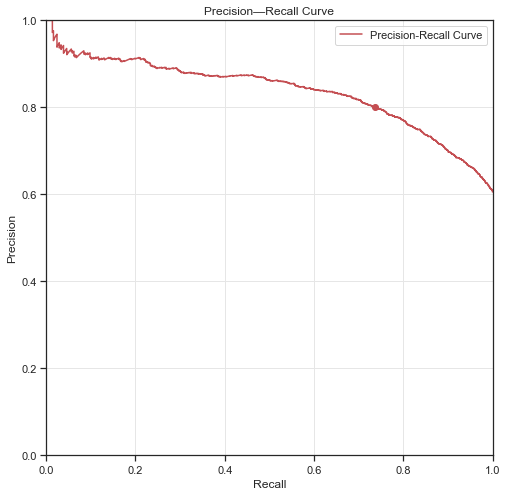


Area Under PR Curve (AP): 0.84
 ### I.b. Precision Recall and Queue plot


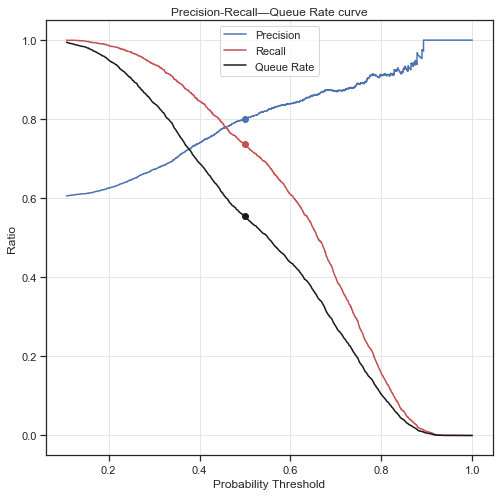

 # II. ROC
 ROC Plot


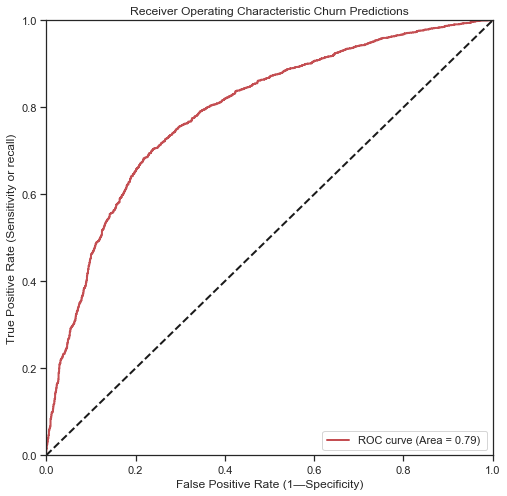

 # III. Lift Chart
 #### Group by predicted probability deciles
Total positive observation: 2528
Total observations: 4195
Observed Positive Class Rate: 60.26 %

Decile Limits:
[(0.9376991883719609, 0.8028028568804374)]
 ### III.a. Observed Responce Rate


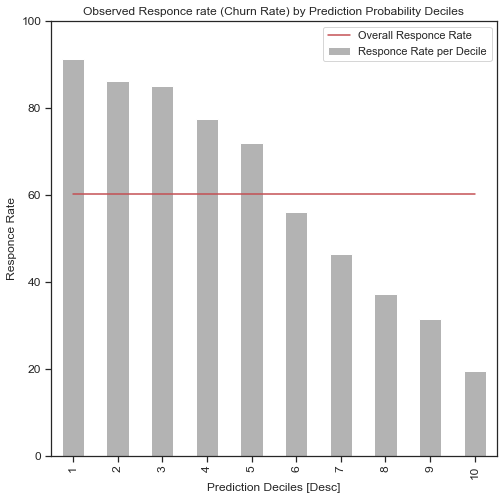

 ### III.b. Lift Chart



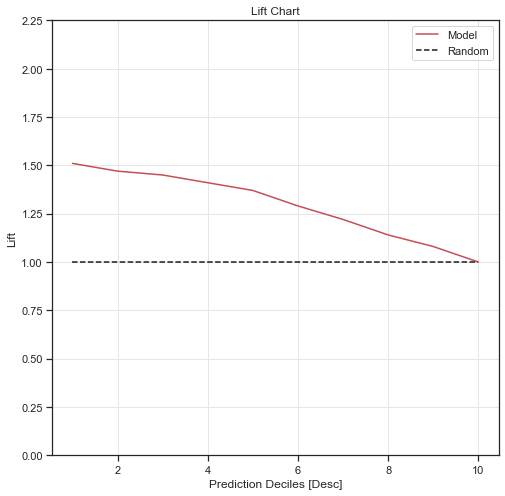

ERROR


In [503]:
binary_classification_validation(validation_dataframe)

In [505]:
len(feature_importances0)

106

In [506]:
df_ml.drop(feature_importances0, axis=1, inplace=True)

In [507]:
df_ml.to_csv('E:\\User\\jupyter\\df_ml.csv', index=False)

In [2]:
df_ml = pd.read_csv('E:\\User\\jupyter\\df_ml.csv',dtype={'read_intime':'int','pages':'int','session_nunique':'int'}, low_memory=False)

In [72]:
import xgboost as xgb

modelXGB = xgb.XGBRegressor().fit(x_train, y_train)


[16:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [99]:
modelXGB.evals_result

<bound method XGBModel.evals_result of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>

In [103]:
modelXGB.score(x, y)

0.21561327076001058